In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import warnings
warnings.simplefilter(action='ignore')

In [2]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [3]:
#Preparing data

data = pd.read_csv("dog-breed-identification/labels.csv")
label_to_int = {str(breed): idx for idx, breed in enumerate(data['breed'].unique())}
X_train, X_test, y_train, y_test = train_test_split(data.id, data.breed, test_size=0.2, random_state=5)
len_X_test = len(X_test)

y_train = np.asarray([label_to_int[label] for label in y_train]).astype(np.int64)
y_test = np.asarray([label_to_int[label] for label in y_test]).astype(np.int64)

X_train = tf.constant([f'dog-breed-identification/train/{str(image)}.jpg' for image in X_train.values])
y_train = tf.constant(y_train)
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.map(_parse_function).batch(17)

X_test = tf.constant([f'dog-breed-identification/train/{str(image)}.jpg' for image in X_test.values])
y_test = tf.constant(y_test)
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.map(_parse_function).batch(len_X_test)

In [4]:
#Importing already trained layers

base_layers = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
base_layers.trainable = False

In [8]:
#Creating a model

model = tf.keras.Sequential([
    base_layers,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(120, activation='softmax')
])
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
#Fitting

model.fit(train, epochs=5)

Epoch 1/5
481/481 [==============================] - 191s 393ms/step - loss: 1.6623 - accuracy: 0.5767
Epoch 2/5
481/481 [==============================] - 197s 410ms/step - loss: 0.5855 - accuracy: 0.8262
Epoch 3/5
481/481 [==============================] - 197s 409ms/step - loss: 0.3815 - accuracy: 0.8894
Epoch 4/5
481/481 [==============================] - 197s 410ms/step - loss: 0.2593 - accuracy: 0.9356
Epoch 5/5
481/481 [==============================] - 197s 409ms/step - loss: 0.1909 - accuracy: 0.9546


In [10]:
#Testing the model

X_test, y_test = zip(*test)
y_pred = model.predict(X_test[:1])
y_pred_int = [np.argmax(pred) for pred in y_pred]
accuracy = accuracy_score(np.array(y_test)[0], y_pred_int)
accuracy

64/64 [==============================] - 43s 666ms/step


0.7511002444987775

1/1 [==============================] - 0s 41ms/step


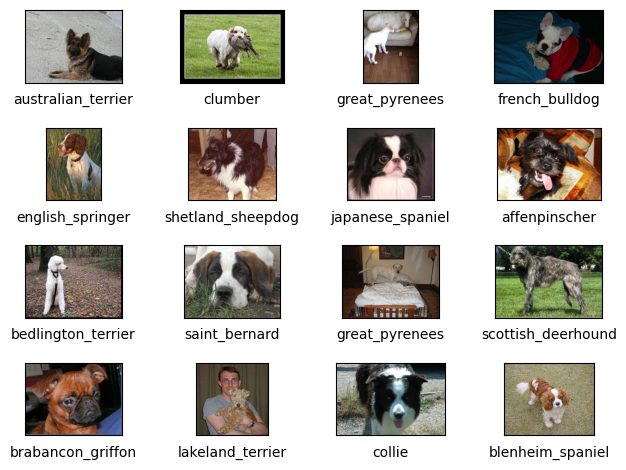

In [13]:
#Testing with visualization

def resize_image(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img, label

for i in range(16):
    img = load_img(f'dog-breed-identification/mytest/{i}.jpg')
    img_array = img_to_array(img)
    img_resized, _ = resize_image(img_array, _)
    img_expended = np.expand_dims(img_resized, axis=0)
    prediction = model.predict(img_expended)
    breed = [k for k, v in label_to_int.items() if v == np.argmax(prediction[0])][0]
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(breed)